In [1]:
import csv
import time
from pathlib import Path

import click
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import HTML
from torch.nn import MSELoss
from torch.nn.functional import normalize
from tqdm import tqdm

from diffdrr import DRR, load_example_ct
from diffdrr.metrics import geodesic, XCorr2
from diffdrr.utils import reshape_subsampled_drr
from diffdrr.visualization import animate, plot_drr

from registration import get_true_drr, get_initial_parameters

In [2]:
# from diffdrr.utils.camera import Rxyz


# def geodesic(drr1, drr2):
#     """Calculate the geodesic distance between two 6DoF projectors."""
#     assert drr1.sdr == drr2.sdr
#     assert drr1.device == drr2.device

#     # Translational distance
#     d_translation = torch.linalg.norm(drr1.translations.data - drr2.translations.data)
    
#     # Rotational distance
#     R1 = Rxyz(drr1.rotations, drr1.device).squeeze()
#     R2 = Rxyz(drr2.rotations, drr2.device).squeeze()
#     ones = normalize(torch.ones(1, 3)).squeeze().to(drr1.device) * drr1.sdr
#     rotated = (R1 @ ones) @ (R2 @ ones) / drr1.sdr.pow(2)
#     d_rotation = drr1.sdr * torch.arccos(rotated)
    
#     return d_translation, d_rotation

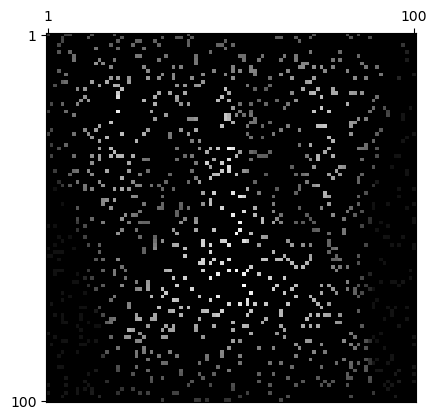

In [3]:
# Get the ground truth DRR
volume, spacing, true_params = get_true_drr()
drr_gt = DRR(volume, spacing, height=100, delx=10.0, subsample=1e3, reshape=False, device="cuda")
ground_truth = drr_gt(**true_params)

plot_drr(reshape_subsampled_drr(ground_truth, drr_gt.detector, 1))
plt.show()

tensor([132.8794], device='cuda:0', grad_fn=<AddBackward0>)


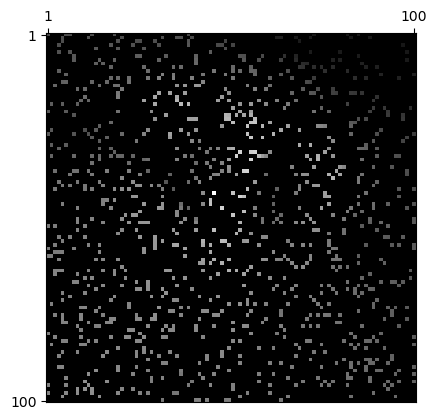

In [4]:
# Initialize the DRR and optimization parameters
sdr, theta, phi, gamma, bx, by, bz = get_initial_parameters(true_params)
drr_est = DRR(volume, spacing, height=100, delx=10.0, subsample=drr_gt.detector.subsample, reshape=False, device="cuda")
estimate = drr_est(sdr, theta, phi, gamma, bx, by, bz)

print(geodesic(drr_gt, drr_est))

plot_drr(reshape_subsampled_drr(estimate, drr_est.detector, 1))
plt.show()

In [5]:
def run_convergence_exp(
    n_itrs=10,
    drr=drr_est,
    ground_truth=ground_truth,
    true_params=true_params,
    filename="./tmp.csv",
    debug=False,
    lr_rotations=5e-2,
    lr_translations=5e0,
    momentum=0.9,
    dampening=0.3,
):
    # Initialize the DRR and optimization parameters
    sdr, theta, phi, gamma, bx, by, bz = get_initial_parameters(true_params)
    _ = drr(sdr, theta, phi, gamma, bx, by, bz)  # Initialize the DRR generator

    # Criterion
    criterion = MSELoss()
    # xcorr2 = XCorr2(zero_mean_normalized=True)
    # criterion = lambda a, b: -xcorr2(a, b)

    # Optimizer
    # optimizer = torch.optim.SGD(
    #     [
    #         {"params": [drr.rotations], "lr": 8.5e-2},
    #         {"params": [drr.translations], "lr": 7.5e2},
    #     ],
    #     momentum=momentum,
    #     dampening=dampening,
    # )
    optimizer = torch.optim.Adam(
        [
            {"params": [drr.rotations], "lr": lr_rotations},
            {"params": [drr.translations], "lr": lr_translations},
        ],
    )

    with open(filename, "w") as f:

        # Start the training log
        writer = csv.writer(f, delimiter=",")
        writer.writerow(
            ["itr", "time", "loss", "geodesic", "theta", "phi", "gamma", "bx", "by", "bz"]
        )
        t0 = time.perf_counter()

        # Start the training loop
        for itr in tqdm(range(n_itrs)):

            # Forward pass: compute the predicted DRR
            estimate = drr()
            t1 = time.perf_counter()

            # Compute the negative ZNCC as loss
            loss = criterion(ground_truth, estimate)
            d_translation, d_rotation = geodesic(drr_gt, drr)
            geo_dist = d_translation + d_rotation
            theta, phi, gamma = drr.rotations.squeeze()
            bx, by, bz = drr.translations.squeeze()
            writer.writerow(
                [itr, t1 - t0]
                + [i.item() for i in [loss, geo_dist, theta, phi, gamma, bx, by, bz]]
            )

            if debug:
                if itr % 10 == 0:
                    tqdm.write(f"{itr}: {d_translation.item(), d_rotation.item()}")
            if geo_dist < 1e0:
                tqdm.write(f"Converged in {itr} iterations")
                break

            # Backward pass: update the weights
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            t0 = t1
            
    return pd.read_csv(filename)

In [12]:
df = run_convergence_exp(150, debug=True)

  3%|██▋                                                                              | 5/150 [00:00<00:02, 48.87it/s]

0: (11.27324390411377, 193.3146514892578)
10: (20.890775680541992, 115.2968521118164)


 19%|███████████████▍                                                                | 29/150 [00:00<00:02, 53.92it/s]

20: (11.202848434448242, 34.573944091796875)
30: (11.112521171569824, 15.104511260986328)


 31%|█████████████████████████                                                       | 47/150 [00:00<00:01, 53.15it/s]

40: (3.1878483295440674, 7.0580153465271)
50: (3.18447208404541, 8.771299362182617)


 43%|██████████████████████████████████▋                                             | 65/150 [00:01<00:01, 52.20it/s]

60: (2.510488271713257, 5.616905212402344)
Converged in 65 iterations


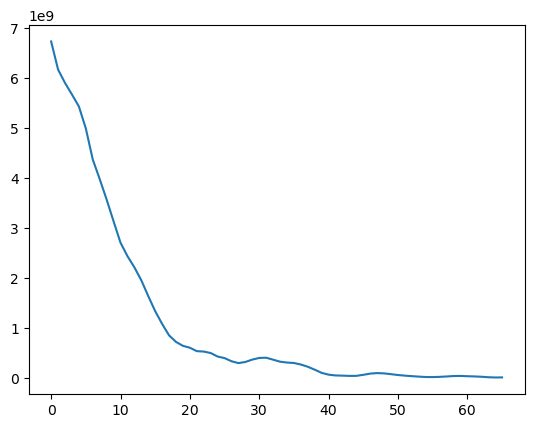

In [13]:
plt.plot(df["loss"])
plt.show()

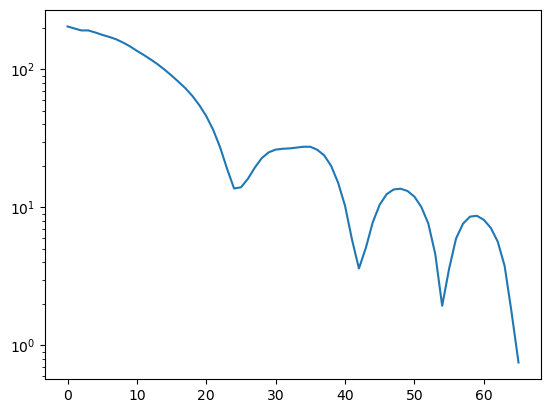

In [14]:
plt.plot(df["geodesic"])
plt.yscale("log")
plt.show()

In [15]:
df.head()

itr      time          loss    geodesic     theta       phi     gamma  \
0    0  0.007189  6.730732e+09  204.587891  3.622012  0.920146  1.474332   
1    1  0.029225  6.168500e+09  197.741684  3.572012  0.870146  1.424332   
2    2  0.019722  5.900580e+09  191.488983  3.521981  0.820599  1.394998   
3    3  0.018978  5.669103e+09  191.486679  3.513463  0.783255  1.360219   
4    4  0.017121  5.430003e+09  184.945312  3.491521  0.748460  1.355489   

           bx          by          bz  
0  171.157120  179.635406  173.232590  
1  166.157120  184.635406  168.232590  
2  162.210754  188.822495  163.288925  
3  161.174988  193.316772  159.054092  
4  162.521683  193.700134  154.711487

In [16]:
df.tail()

itr      time        loss  geodesic     theta       phi     gamma  \
61   61  0.023729  26508576.0  7.112204  3.120536 -0.014846  1.573507   
62   62  0.019311  20457404.0  5.654545  3.125341 -0.013999  1.572689   
63   63  0.016975  10576585.0  3.769697  3.131979 -0.011554  1.573737   
64   64  0.016856   5631649.5  1.740541  3.139769 -0.007871  1.575380   
65   65  0.019006   7123485.5  0.751540  3.146980 -0.003662  1.575144   

            bx          by          bz  
61  181.014236  180.753357  167.736115  
62  180.703430  180.339539  167.350876  
63  180.271484  180.164841  166.940994  
64  179.838577  180.160706  166.514618  
65  179.542892  180.150574  166.105255

In [20]:
drr_est.reshape = True
drr_gt.reshape = True
HTML(animate(df.iloc[::2], sdr=200.0, drr=drr_est, ground_truth=drr_gt(**true_params)))

Precomputing DRRs: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 145.11it/s]


In [17]:
drr = DRR(volume, spacing, height=100, delx=10.0, reshape=True, device="cuda")
HTML(animate(df.iloc[::2], sdr=200.0, drr=drr, ground_truth=drr(**true_params)))

Precomputing DRRs: 100%|██████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 74.86it/s]
